# Calibration of the flooding model with gaussian non linear least squares (ThreeDVAR)

The goal of this example is to calibrate the simulator associated with the flooding model with gaussian linear least squares. 



In [1]:
import openturns as ot
import numpy as np
import PostCalibrationResult as pcr

## Read the observations

We begin by reading the observations from the data file. There are 100 observations of the couple (Q,H).

In [2]:
observedSample = ot.Sample_ImportFromCSVFile("calibration_flooding_observations.csv")
nbobs = observedSample.getSize()
Qobs = observedSample[:,0]
Hobs = observedSample[:,1]
nbobs

100

In [3]:
Hobs.setDescription(["Height (m)"])

## Define the model

We define the model which has 4 inputs and one output H.

In [4]:
def functionFloodingModel(X):
    Q, K_s, Z_v, Z_m = X
    L = 5.0e3
    B = 300.0
    alpha = (Z_m - Z_v)/L
    H = (Q/(K_s*B*np.sqrt(alpha)))**(3.0/5.0)
    return [H]

In [5]:
modelPyFunc = ot.PythonFunction(4, 1, functionFloodingModel)
modelPyFunc.setDescription(["Q", "Ks", "Zv", "Zm","H"])

Define the value of the reference values of the $\theta$ parameter. In the bayesian framework, this is called the mean of the *prior* gaussian distribution. In the data assimilation framework, this is called the *background*.

In [6]:
KsInitial = 20.
ZvInitial = 49.
ZmInitial = 51.
thetaPrior = ot.Point([KsInitial,ZvInitial,ZmInitial])
thetaPrior.setDescription(("Ks","Zv","Zm"))

The following statement create the calibrated function from the model. The calibrated parameters Ks, Zv, Zm are at indices 1, 2, 3 in the inputs arguments of the model.

In [7]:
calibratedIndices = [1,2,3]
mycf = ot.ParametricFunction(modelPyFunc, calibratedIndices, thetaPrior)

## Calibration

The standard deviation of the observations.

In [8]:
sigmaH = 0.5 # (m^2)

Define the covariance matrix of the output Y of the model.

In [9]:
errorCovariance = ot.CovarianceMatrix(1)
errorCovariance[0,0] = sigmaH**2

Defined the covariance matrix of the parameters $\theta$ to calibrate.

In [10]:
sigmaKs = 5.
sigmaZv = 1.
sigmaZm = 1.

In [11]:
sigma = ot.CovarianceMatrix(3)
sigma[0,0] = sigmaKs**2
sigma[1,1] = sigmaZv**2
sigma[2,2] = sigmaZm**2
sigma

class=CovarianceMatrix dimension=3 implementation=class=MatrixImplementation name=Unnamed rows=3 columns=3 values=[25,0,0,0,1,0,0,0,1]

The `ThreeDVAR` class performs the gaussian nonlinear calibration.

In [12]:
algo = ot.ThreeDVAR(mycf, Qobs, Hobs, thetaPrior, sigma, errorCovariance)

The `run` method computes the solution of the problem.

In [13]:
algo.run()

In [14]:
calibrationResult = algo.getResult()

## Analysis of the results

The `getParameterMAP` method returns the maximum of the posterior distribution of $\theta$.

In [15]:
thetaStar = calibrationResult.getParameterMAP()
thetaStar

class=Point name=Unnamed dimension=3 values=[30.5694,47.637,52.363]

In [16]:
mypcr = pcr.PostCalibrationResult(calibrationResult,mycf, Qobs,Hobs)

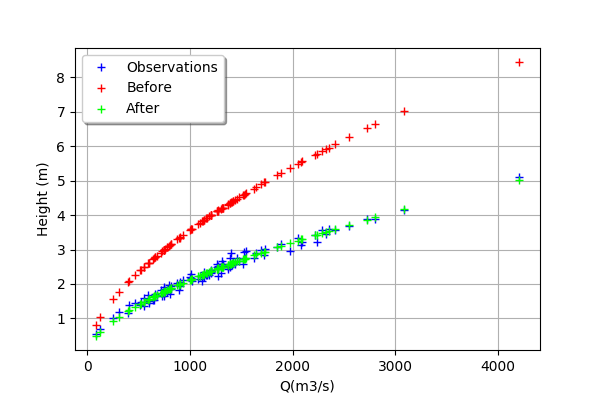

In [17]:
graph = mypcr.drawModelVsObservations()
graph.setLegendPosition("topleft")
graph

We see that the output of the model after calibration is in the middle of the observations: the calibration seems correct.

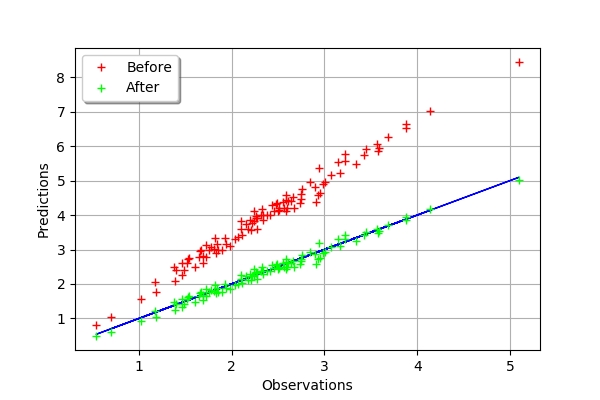

In [19]:
mypcr.drawObservationsVsPredictions()

The fit is excellent after calibration. Indeed, the cloud of points after calibration is on the diagonal. 

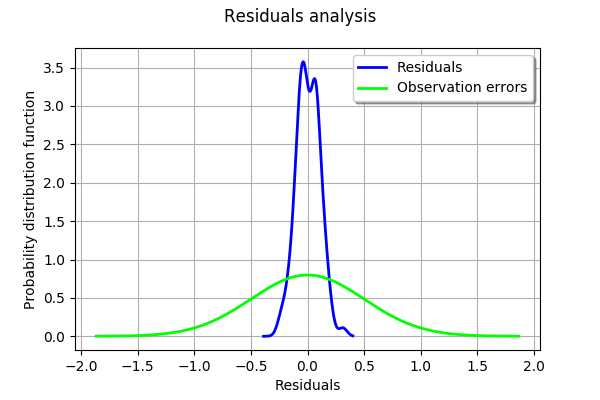

In [20]:
mypcr.drawResiduals()

We see that the histogram of the residual is centered on zero. This is a proof that the calibration did perform correctly.

The `getParameterPosterior` method returns the posterior gaussian distribution of $\theta$.

In [21]:
distributionPosterior = calibrationResult.getParameterPosterior()

We can compute a 95% confidence interval of the parameter $\theta^\star$.

In [22]:
distributionPosterior.computeBilateralConfidenceIntervalWithMarginalProbability(0.95)[0]

class=Interval name=Unnamed dimension=3 lower bound=class=Point name=Unnamed dimension=3 values=[30.5632,47.5662,52.3623] upper bound=class=Point name=Unnamed dimension=3 values=[31.1221,47.6377,52.4338] finite lower bound=[1,1,1] finite upper bound=[1,1,1]

We see that there is a small uncertainty on the value of all parameters.

We can compare the prior and posterior distributions of the marginals of $\theta$. 

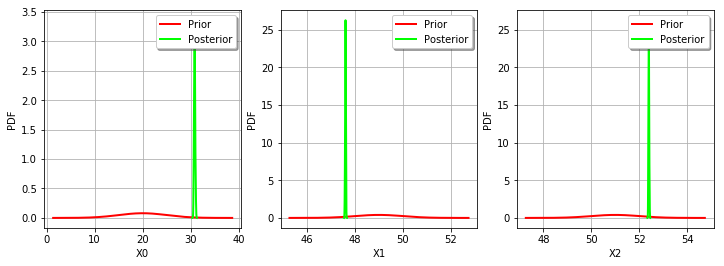

In [24]:
_ = mypcr.drawThetaDistribution()

The two distributions are very different, with a spiky posterior distribution. This shows that the calibration is very sensible to the observations. 

## Tuning the posterior distribution estimation

The "ThreeDVAR-BootstrapSize" key controls the posterior distribution estimation.

* If "ThreeDVAR-BootstrapSize" > 0 (by default it is equal to 100), then a bootstrap resample algorithm is used to see the dispersion of the MAP estimator. This allows to see the variability of the estimator with respect to the finite observation sample.
* If "ThreeDVAR-BootstrapSize" is zero, then the gaussian linear calibration estimator is used (i.e. the `BLUE` class) at the optimum. This is called the Laplace approximation. 

In [25]:
ot.ResourceMap_SetAsUnsignedInteger("ThreeDVAR-BootstrapSize",0) 

In [26]:
algo.run()

In [27]:
calibrationResult = algo.getResult()

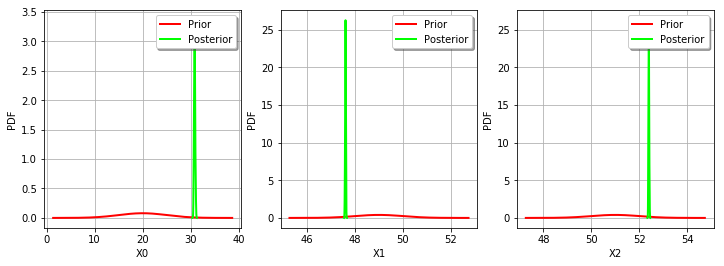

In [28]:
_ = mypcr.drawThetaDistribution()

As we can see, this does not change much the posterior distribution, which remains spiky. 